# Initial Exploration of Rotary Positional Embeddings (RoPE)

RoPE was first introduced in a series of blog posts
([here](https://kexue.fm/archives/8130) and [here](https://kexue.fm/archives/8265)
if you speak Chinese), and later published in [this](https://arxiv.org/abs/2104.09864) paper.

The key difference with rotary positional embeddings as compared to
previous methods is that you insert the positional information through
multiplication as opposed to addition.
To understand the intuition behind the method one must consider the core
operation modern Self-Attention is built upon, the dot product, and its
relationship to the angle of two vectors.

## RoPE Basics

**Dot Product:**

When calculating the dot product between two vectors, one most often uses
the coordinate definition, that is:

$$
\textbf{a}\cdot\textbf{b}=\sum_{i=1}^{n}a_{i}b_{i}=a_{1}b_{1}+a_{2}b_{2}+...+a_{n}b_{n}
$$

However, we can also express the dot product using the angle between two
vectors and their magnitude (geometric definition):

$$
\textbf{a}\cdot\textbf{b}=||a||\, ||b||\cos\theta
$$

The geometric definition is the key reason the dot product is used as a
similarity measure.
In fact, the angle between vectors in higher dimensions is often defined
by simply re-arranging the dot product:

$$
\theta=\cos^{-1}\frac{a\cdot b}{||a||\, ||b||}
$$

**Dot Product as a Similarity Measure:**

This section is a bit of a side-quest, but I find it very interesting, so
I'll leave it in.

Considering the dot product between two vectors as their similarity, a
high value would indicate two similar vectors and a low value dissimilarity.
Because of the relation to angles, the lowest value for the dot product
will be when the two vectors are at an angle of 180 degrees, while the
highest will be at an angle of zero.

Check out:
https://transformer-circuits.pub/2022/toy_model/index.html#strategic-ways-out


In [1]:
import torch
import seaborn as sns
import math
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import time

emb_dim = 768


In [2]:
def compute_freqs_cis(dim: int, t: torch.tensor, theta: float = 10000.0):
    """
    Compute the frequency tensor for complex exponentials (cis) with given dimensions.

    This function calculates a frequency tensor with complex exponentials using the given dimension 'dim'
    and the time 't'. The 'theta' parameter scales the frequencies.
    The returned tensor contains complex values in complex64 data type.

    Args:
        dim (int): Dimension of the frequency tensor.
        t (tensor): End index for precomputing frequencies.
        theta (float, optional): Scaling factor for frequency computation. Defaults to 10000.0.

    Returns:
        torch.Tensor: Precomputed frequency tensor with complex exponentials.
    """
    freqs = 1.0 / (
                theta ** (torch.arange(0, dim, 2)[: (dim // 2)].float() / dim))
    freqs = torch.outer(t, freqs).float()  # type: ignore
    freqs_cis = torch.polar(torch.ones_like(freqs), freqs)  # complex64
    return freqs_cis


def reshape_for_broadcast(freqs_cis: torch.Tensor, x: torch.Tensor):
    """
    Reshape frequency tensor for broadcasting it with another tensor.

    This function reshapes the frequency tensor to have the same shape as the target tensor 'x'
    for the purpose of broadcasting the frequency tensor during element-wise operations.

    Args:
        freqs_cis (torch.Tensor): Frequency tensor to be reshaped.
        x (torch.Tensor): Target tensor for broadcasting compatibility.

    Returns:
        torch.Tensor: Reshaped frequency tensor.

    Raises:
        AssertionError: If the frequency tensor doesn't match the expected shape.
        AssertionError: If the target tensor 'x' doesn't have the expected number of dimensions.
    """
    ndim = x.ndim
    assert 0 <= 1 < ndim
    assert freqs_cis.shape == (x.shape[1], x.shape[-1])
    shape = [d if i == 1 or i == ndim - 1 else 1 for i, d in
             enumerate(x.shape)]
    return freqs_cis.view(*shape)


def apply_rotary_emb(
        xq: torch.Tensor,
        xk: torch.Tensor,
        freqs_cis: torch.Tensor,
) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Apply rotary embeddings to input tensors using the given frequency tensor.

    This function applies rotary embeddings to the given query 'xq' and key 'xk' tensors using the provided
    frequency tensor 'freqs_cis'. The input tensors are reshaped as complex numbers, and the frequency tensor
    is reshaped for broadcasting compatibility. The resulting tensors contain rotary embeddings and are
    returned as real tensors.

    Args:
        xq (torch.Tensor): Query tensor to apply rotary embeddings.
        xk (torch.Tensor): Key tensor to apply rotary embeddings.
        freqs_cis (torch.Tensor): Precomputed frequency tensor for complex exponentials.

    Returns:
        Tuple[torch.Tensor, torch.Tensor]: Tuple of modified query tensor and key tensor with rotary embeddings.
    """
    xq_ = torch.view_as_complex(xq.float().reshape(*xq.shape[:-1], -1, 2))
    xk_ = torch.view_as_complex(xk.float().reshape(*xk.shape[:-1], -1, 2))
    freqs_cis = reshape_for_broadcast(freqs_cis, xq_)
    xq_out = torch.view_as_real(xq_ * freqs_cis).flatten(3)
    xk_out = torch.view_as_real(xk_ * freqs_cis).flatten(3)
    return xq_out.type_as(xq), xk_out.type_as(xk)


class RoPENd(torch.nn.Module):
    """N-dimensional Rotary Positional Embedding."""
    def __init__(self, n_dims, d_model, base=10000):
        super(RoPENd, self).__init__()

        k_max = d_model // (2 * n_dims)
        self.n_dims = n_dims

        assert d_model % k_max == 0, f'shape[-1] ({d_model}) is not divisible by 2 * len(shape[:-1]) ({2 * len(n_dims)})'

        self.buff = self.register_buffer("theta_ks", 1 / (base ** (torch.arange(k_max) / k_max)))

    def build_angles(self, positions: list[torch.tensor]):
        # create a stack of angles multiplied by position
        angles = torch.cat([t.unsqueeze(-1) * self.theta_ks for t in
                            torch.meshgrid(positions, indexing='ij')], dim=-1)
        # convert to complex number to allow easy rotation
        rotations = torch.polar(torch.ones_like(angles), angles)
        return rotations

    def forward(self, x, positions: list[torch.tensor]):
        # convert input into complex numbers to perform rotation
        x = torch.view_as_complex(x.reshape(*x.shape[:-1], -1, 2))
        rotation = self.build_angles(positions)
        pe_x = rotation * x
        return torch.view_as_real(pe_x).flatten(-2)


In [3]:
def test_rope(times: torch.tensor, emb_dim: int = 768):
    embs = torch.ones((1, times.shape[0], emb_dim))
    embs = embs.view(embs.shape[0], embs.shape[1], 1, embs.shape[2])
    freq_emb = compute_freqs_cis(emb_dim, times)
    q, k = apply_rotary_emb(embs, embs, freq_emb)
    k = k.transpose(1, 2)
    q = q.transpose(1, 2)
    scores = torch.matmul(q, k.transpose(2, 3)) / math.sqrt(emb_dim)
    scores = scores.squeeze()

    return scores

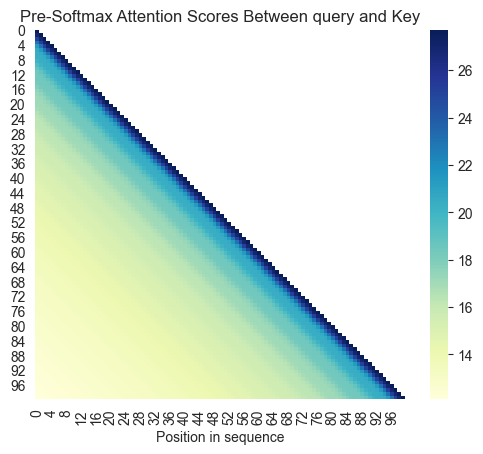

In [4]:
times = torch.arange(0, 100, 1)
scores = test_rope(times, emb_dim)
weight = torch.tensor([1., -1.])[None, None, ...]

scores = scores.cpu().numpy()
mask = np.zeros_like(scores)
mask[np.triu_indices_from(mask, k=1)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(scores, mask=mask, square=True,  cmap="YlGnBu")
    ax.set_xlabel("Position in sequence")
    ax.set_title("Pre-Softmax Attention Scores Between query and Key")

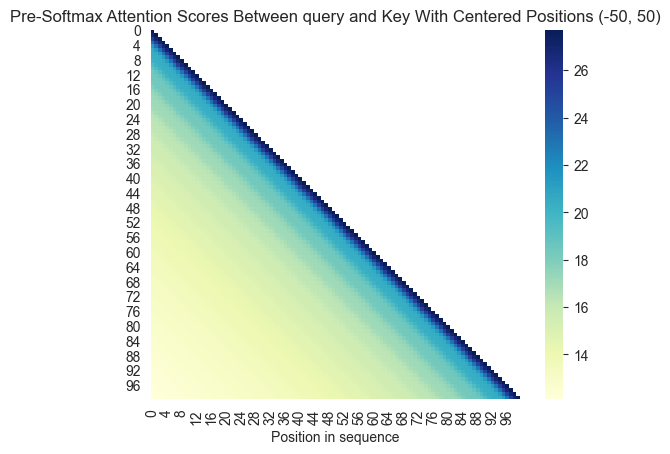

In [5]:
times = torch.arange(-50, 50, 1)
scores = test_rope(times, emb_dim)
weight = torch.tensor([1., -1.])[None, None, ...]

scores = scores.cpu().numpy()
mask = np.zeros_like(scores)
mask[np.triu_indices_from(mask, k=1)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(scores, mask=mask, square=True,  cmap="YlGnBu")
    ax.set_xlabel("Position in sequence")
    ax.set_title("Pre-Softmax Attention Scores Between query and Key With Centered Positions (-50, 50)")

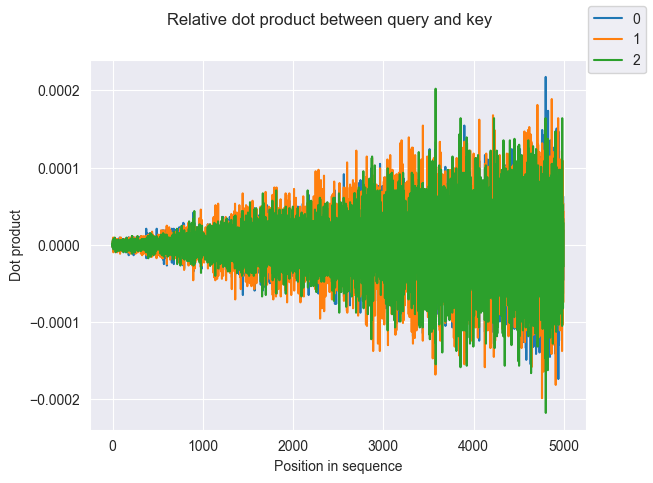

In [6]:
times = torch.arange(0, 5000, 1)
scores = test_rope(times, emb_dim)
neighbouring_scores_1 = torch.diagonal(scores, offset=1)
neighbouring_scores_2 = torch.diagonal(scores, offset=2)
neighbouring_scores_3 = torch.diagonal(scores, offset=3)

fig, ax = plt.subplots()
for idx, r_score in enumerate((neighbouring_scores_1, neighbouring_scores_2, neighbouring_scores_3)):
    relative_distances = F.conv1d(r_score[None, :], weight).cpu().numpy().squeeze()
    ax.plot(list(range(relative_distances.shape[0])), relative_distances, label=f"{idx}")
ax.set_xlabel("Position in sequence")
ax.set_ylabel("Dot product")
fig.suptitle("Relative dot product between query and key")
fig.legend();

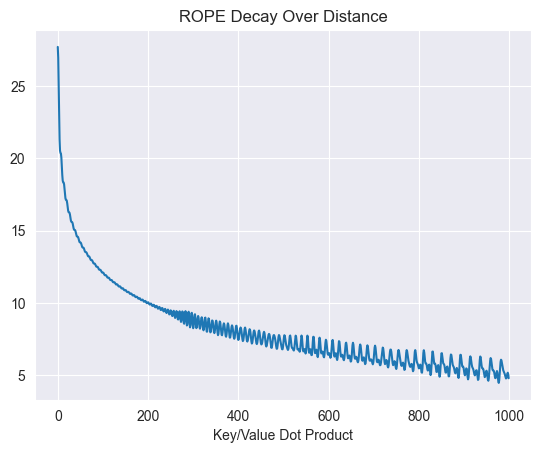

In [7]:
times_reg = torch.arange(0, 1000, 1)
scores_reg = test_rope(times_reg, emb_dim)

fig, ax = plt.subplots()
ax.plot(list(range(scores_reg.shape[1])), scores_reg[0])
ax.set_xlabel("Position in sequence")
ax.set_xlabel("Key/Value Dot Product")
ax.set_title("ROPE Decay Over Distance");

The method seems to work as advertised according to the plots. It even
seems to work when the input positions are negative! This is interesting
because it opens opportunities for us to normalize the token positions.
Going further, let's investigate RoPE in 2D. This is done by cutting
the embedding dimension in half and applying x/y coords to the top/bottom
halves respectively.

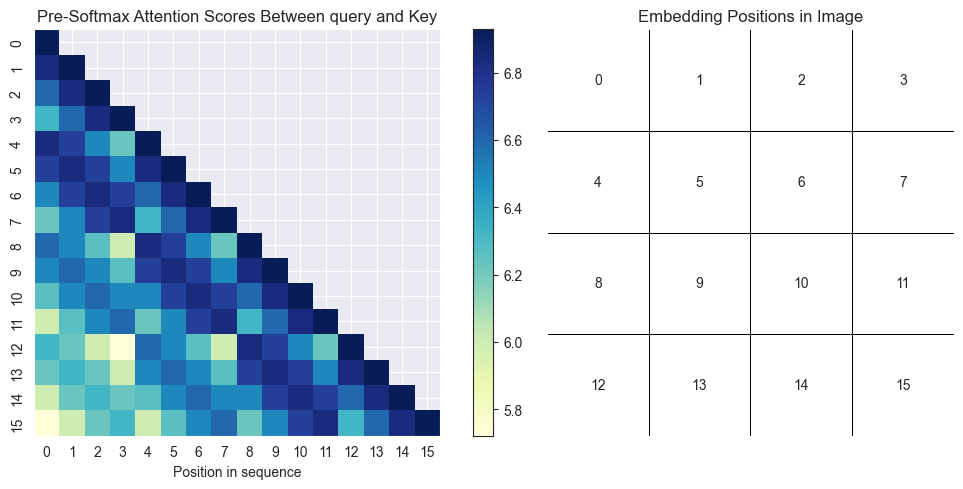

In [9]:
B = 1
C, W, H = 1, 32, 32 # Resolution of image
# We cut a 32x32 image into 4x4 patches
H_p = 8
W_p = 8
img = torch.ones((B, C, W, H))
# # Patch + Channels -> embedding linear layer
proj = torch.ones((emb_dim, H_p*W_p*C))

NH = H // H_p
NW = W // W_p

img = img.reshape(B, NH, NW, C, H_p, W_p)
img = img.reshape(B, NH, NW, -1)
img = img.reshape(B, NH*NW, -1)

# Batch matrix multiply to go from H_p*W_p -> emb_dim
emb = torch.bmm(img, proj.view(B, -1, emb_dim))
emb.fill_(0.5) # For visualization purposes

emb = emb.reshape(B, NH, NW, emb_dim)

# Apply height positions
pos_emb = RoPENd(2, emb_dim)
positions = [torch.arange(0, NH, 1), torch.arange(0, NW, 1)]
emb = pos_emb(emb, positions)

# Flatten everyting again
emb = emb.reshape(B, NH*NW, emb_dim)

k, q = emb, emb
scores = torch.bmm(q, k.permute(0, 2, 1)) / math.sqrt(emb_dim)
scores = scores.squeeze()

scores = scores.cpu().numpy()
mask = np.zeros_like(scores)
mask[np.triu_indices_from(mask, k=1)] = True
fig, ax = plt.subplots(1, 2, figsize=(12, 5), tight_layout=True)
with sns.axes_style("white"):
    sns.heatmap(scores, mask=mask, square=True,  cmap="YlGnBu", ax=ax[0])
    ax[0].set_xlabel("Position in sequence")
    ax[0].set_title("Pre-Softmax Attention Scores Between query and Key")

patch_matr = np.arange(0, NH*NW).reshape(NH, NW)

sns.heatmap(patch_matr, fmt='d', annot=True, square=True,
            cmap='gray_r', vmin=0, vmax=0,
            linewidths=0.5, linecolor='k',
            cbar=False, ax=ax[1])

sns.despine(left=False, right=False, top=False, bottom=False)
ax[1].set_title("Embedding Positions in Image")
ax[1].set(xticklabels=[])
ax[1].set(yticklabels=[]);

Although it's a bit hard to see initially, when comparing the patch
positions and the similarity scores the 2D embedding works!
This is of course not only useful for images, but pretty much any 2D
space where we have data points. The same can be done for N dimensions
as long as the model dimensionality is divisible by N.
I would also like to profile how long this process takes, so let's do
that.

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
n_tests = 100
B, H, W = 64, 16, 16
pos_emb = RoPENd(2, emb_dim).to(device)
test_emb = torch.zeros((B, H, W, emb_dim)).to(device)
pos = torch.arange(0, H, 1).to(device)
times = []
for i in range(n_tests):
    start = time.time()
    emb = pos_emb(test_emb, [pos, pos])
    times.append(time.time() - start)

times = np.array(times)
print(f"Average time per test: {times.mean()}s\n"
      f"Average std: {times.std()}s")
print(f"Tested with batch size {B}, sequence length {H*W} and embedding dimension {emb_dim}.")

Average time per test: 0.00016178369522094728s
Average std: 3.8564015466143874e-05s
Tested with batch size 64, sequence length 256 and embedding dimension 768.


Ok, seems more than fast enough, at least on the GPU.